# Initial data exploration

Take a wee look at some train delay data.

Data obtained from [Network Rail](https://www.networkrail.co.uk/who-we-are/transparency-and-ethics/transparency/open-data-feeds/). It should be downloaded and unzipped into the `data/raw/` folder.
 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
current_directory = os.getcwd()
print(current_directory)

/mnt/c/Users/yshang/OneDrive - Tessella Ltd/Documents/Training/GNN/train-delays/notebooks


## Load  data


In [3]:
data = pd.read_csv("../data/raw/raw_delays_01.csv")
metadata = pd.read_excel("../data/raw/metadata.xlsx", sheet_name=None)

/tmp/ipykernel_831/3272456270.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/raw/raw_delays_01.csv")


ValueError: Excel file format cannot be determined, you must specify an engine manually.

In [22]:
data.columns

Index(['FINANCIAL_YEAR_PERIOD', 'ORIGIN_DEPARTURE_DATE', 'TRUST_TRAIN_ID',
       'PLANNED_ORIGIN_LOCATION_CODE', 'PLANNED_ORIGIN_WTT_DATETIME',
       'PLANNED_ORIGIN_GBTT_DATETIME', 'PLANNED_DEST_LOCATION_CODE',
       'PLANNED_DEST_WTT_DATETIME', 'PLANNED_DEST_GBTT_DATETIME',
       'TRAIN_SERVICE_CODE', 'SERVICE_GROUP_CODE', 'TOC_CODE',
       'ENGLISH_DAY_TYPE', 'APPLICABLE_TIMETABLE_FLAG', 'TRAIN_SCHEDULE_TYPE',
       'TRACTION_TYPE', 'TRAILING_LOAD', 'TIMING_LOAD', 'UNIT_CLASS',
       'INCIDENT_NUMBER', 'INCIDENT_CREATE_DATE', 'INCIDENT_START_DATETIME',
       'INCIDENT_END_DATETIME', 'SECTION_CODE', 'NR_LOCATION_MANAGER',
       'RESPONSIBLE_MANAGER', 'INCIDENT_REASON', 'ATTRIBUTION_STATUS',
       'INCIDENT_EQUIPMENT', 'INCIDENT_DESCRIPTION', 'REACT_REASON',
       'INCIDENT_RESP_TRAIN', 'RESP_TRAIN', 'REACT_TRAIN', 'EVENT_TYPE',
       'START_STANOX', 'END_STANOX', 'EVENT_DATETIME', 'PFPI_MINUTES',
       'NON_PFPI_MINUTES'],
      dtype='object')

Reading from the [documentation](docs/Explanation-of-historic-attributed-delays.pdf), some of these columns can immediately be discarded.

In [23]:
columns_to_drop = ['FINANCIAL_YEAR_PERIOD','ORIGIN_DEPARTURE_DATE', 'APPLICABLE_TIMETABLE_FLAG', 
                   'TRAIN_SCHEDULE_TYPE', 'TRACTION_TYPE', 'TRAILING_LOAD', 'TIMING_LOAD', 'UNIT_CLASS', 'INCIDENT_NUMBER',
                   'RESPONSIBLE_MANAGER', 'ATTRIBUTION_STATUS', 'INCIDENT_EQUIPMENT']
data.drop(columns=columns_to_drop, inplace=True)

In [24]:
# print the remaining columns
data.columns

Index(['TRUST_TRAIN_ID', 'PLANNED_ORIGIN_LOCATION_CODE',
       'PLANNED_ORIGIN_WTT_DATETIME', 'PLANNED_ORIGIN_GBTT_DATETIME',
       'PLANNED_DEST_LOCATION_CODE', 'PLANNED_DEST_WTT_DATETIME',
       'PLANNED_DEST_GBTT_DATETIME', 'TRAIN_SERVICE_CODE',
       'SERVICE_GROUP_CODE', 'TOC_CODE', 'ENGLISH_DAY_TYPE',
       'INCIDENT_CREATE_DATE', 'INCIDENT_START_DATETIME',
       'INCIDENT_END_DATETIME', 'SECTION_CODE', 'NR_LOCATION_MANAGER',
       'INCIDENT_REASON', 'INCIDENT_DESCRIPTION', 'REACT_REASON',
       'INCIDENT_RESP_TRAIN', 'RESP_TRAIN', 'REACT_TRAIN', 'EVENT_TYPE',
       'START_STANOX', 'END_STANOX', 'EVENT_DATETIME', 'PFPI_MINUTES',
       'NON_PFPI_MINUTES'],
      dtype='object')

The Train service codes denote different kinds of trains including freight and cargo, we need to filter for just passenger trains.

The documentation provides the train company code with their corresponding operating company. There were more than 100 companies in total, and I wasn't going to look all of them up so I passed the list to ChatGPT to return me the passenger trains. 

In [56]:
passenger_train_companies = [
    "E1",  # GWR Charters
    "EA",  # TPE
    "EB",  # Greater Anglia
    "EC",  # Grand Central
    "ED",  # Northern Trains
    "EF",  # GWR
    "EH",  # CrossCountry
    "EI",  # Wrexham & Shrops
    "EJ",  # West Midlands Trains
    "EK",  # London Overground
    "EM",  # EMR
    "ES",  # Caledonian Sleeper
    "ET",  # GTR
    "EX",  # TfL Rail
    "HA",  # ScotRail
    "HB",  # LNER
    "HG",  # Central
    "HH",  # VXC
    "HI",  # MML
    "HJ",  # GWR HSTs
    "HL",  # Transport for Wales 
    "HT",  # c2c
    "HU",  # Southeastern
    "HX",  # Thameslink
    "HY"   # South Western Railway
]
passenger_train_data = data[data['TOC_CODE'].isin(passenger_train_companies)]

In [60]:
print('length of dataset: ' + str(len(data)))
print('length of filtered dataset: ' + str(len(passenger_train_data)))


length of dataset: 332824
length of filtered dataset: 235021


Lets check the most significant companies in the whole dataset and check that we haven't missed any important ones.

<Axes: xlabel='TOC_CODE'>

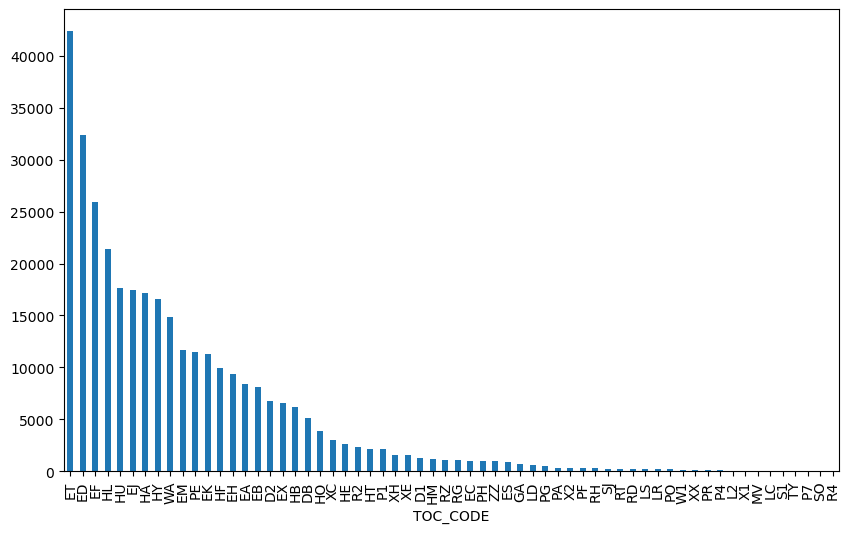

In [58]:
toc = data['TOC_CODE'].value_counts()
plt.figure(figsize=(10, 6))
toc.plot.bar()

<Axes: xlabel='TOC_CODE'>

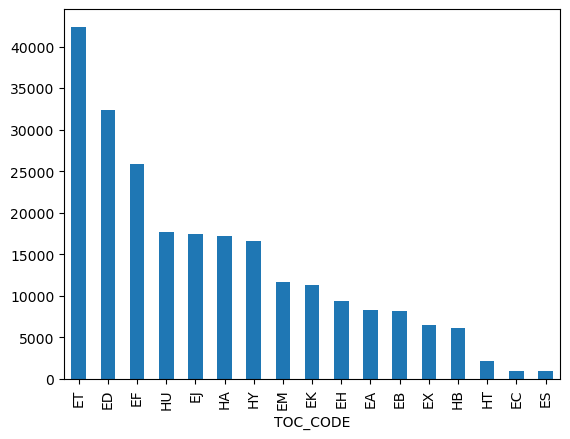

In [59]:
passenger_train_data['TOC_CODE'].value_counts().plot.bar()

## Other features

The other features need a bit of investigating.

In [129]:
columns_to_keep = []
print(passenger_train_data.columns)

Index(['TRUST_TRAIN_ID', 'PLANNED_ORIGIN_LOCATION_CODE',
       'PLANNED_ORIGIN_WTT_DATETIME', 'PLANNED_ORIGIN_GBTT_DATETIME',
       'PLANNED_DEST_LOCATION_CODE', 'PLANNED_DEST_WTT_DATETIME',
       'PLANNED_DEST_GBTT_DATETIME', 'TRAIN_SERVICE_CODE',
       'SERVICE_GROUP_CODE', 'TOC_CODE', 'ENGLISH_DAY_TYPE',
       'INCIDENT_CREATE_DATE', 'INCIDENT_START_DATETIME',
       'INCIDENT_END_DATETIME', 'SECTION_CODE', 'NR_LOCATION_MANAGER',
       'INCIDENT_REASON', 'INCIDENT_DESCRIPTION', 'REACT_REASON',
       'INCIDENT_RESP_TRAIN', 'RESP_TRAIN', 'REACT_TRAIN', 'EVENT_TYPE',
       'START_STANOX', 'END_STANOX', 'EVENT_DATETIME', 'PFPI_MINUTES',
       'NON_PFPI_MINUTES'],
      dtype='object')


We'll start with the columns relating to datetimes:

In [130]:
datetime_columns = ['PLANNED_ORIGIN_WTT_DATETIME', 'PLANNED_ORIGIN_GBTT_DATETIME','INCIDENT_CREATE_DATE', 
                    'INCIDENT_START_DATETIME', 'INCIDENT_END_DATETIME', 'EVENT_DATETIME', 'ENGLISH_DAY_TYPE',
                    'PLANNED_DEST_WTT_DATETIME', 'PLANNED_DEST_GBTT_DATETIME', 'PFPI_MINUTES', 'NON_PFPI_MINUTES']
passenger_train_data[datetime_columns].sample(n=10)

,PLANNED_ORIGIN_WTT_DATETIME,PLANNED_ORIGIN_GBTT_DATETIME,INCIDENT_CREATE_DATE,INCIDENT_START_DATETIME,INCIDENT_END_DATETIME,EVENT_DATETIME,ENGLISH_DAY_TYPE,PLANNED_DEST_WTT_DATETIME,PLANNED_DEST_GBTT_DATETIME,PFPI_MINUTES,NON_PFPI_MINUTES
177407,16-APR-2022 12:35,16-APR-2022 12:35,16-APR-2022 00:00,16-APR-2022 15:20,16-APR-2022 23:20,16-APR-2022 15:14,SA,16-APR-2022 18:33,16-APR-2022 18:33,17.0,0.0
112346,11-APR-2022 15:39,11-APR-2022 15:39,11-APR-2022 00:00,11-APR-2022 14:51,11-APR-2022 23:14,11-APR-2022 15:39,WD,11-APR-2022 17:11,11-APR-2022 17:11,45.0,0.0
195808,19-APR-2022 15:34,19-APR-2022 15:34,12-APR-2022 00:00,06-MAY-2022 23:59,08-MAY-2022 05:00,19-APR-2022 16:41,WD,19-APR-2022 17:50,19-APR-2022 17:50,1.0,0.0
164448,15-APR-2022 08:43,15-APR-2022 08:43,15-APR-2022 00:00,15-APR-2022 09:28,15-APR-2022 17:42,15-APR-2022 09:40,BH,15-APR-2022 10:07,15-APR-2022 10:07,10.0,0.0
263562,25-APR-2022 07:37,25-APR-2022 07:37,25-APR-2022 00:00,25-APR-2022 07:59,25-APR-2022 16:12,25-APR-2022 08:08,WD,25-APR-2022 08:15,25-APR-2022 08:16,3.0,0.0
280330,26-APR-2022 10:05,26-APR-2022 10:05,25-APR-2022 00:00,18-APR-2022 04:45,25-JUL-2022 13:16,26-APR-2022 10:15,WD,26-APR-2022 11:13,26-APR-2022 11:13,0.0,0.0
265338,25-APR-2022 18:30,25-APR-2022 18:30,25-APR-2022 00:00,25-APR-2022 14:52,25-APR-2022 23:12,25-APR-2022 18:34,WD,25-APR-2022 20:33,25-APR-2022 20:34,4.0,0.0
214246,20-APR-2022 11:48,20-APR-2022 11:48,20-APR-2022 00:00,20-APR-2022 12:10,20-APR-2022 20:13,20-APR-2022 12:10,WD,20-APR-2022 12:14,20-APR-2022 12:16,2.0,0.0
232634,21-APR-2022 23:25,21-APR-2022 23:25,22-APR-2022 00:00,21-APR-2022 23:09,22-APR-2022 08:10,22-APR-2022 00:08,WD,22-APR-2022 00:19,22-APR-2022 00:19,4.0,0.0
92234,08-APR-2022 20:31,08-APR-2022 20:31,14-APR-2022 00:00,08-APR-2022 18:45,08-APR-2022 19:30,08-APR-2022 20:41,WD,08-APR-2022 21:21,08-APR-2022 21:23,0.0,0.0


OK, so a few things to note then:

- the WTT ("Working Time Table") and the GBTT ("Great British Time Table") are almost always the same, except sometimes the GBTT is a `NaN`. The GBTT is what the public sees, and the WTT is what the railway staff see. I don't _really_ undestand why they're using two different time tables that are basically the same, but with the amount of NaNs in the GBTT I think its safe to delete these columns.
- I can't find what the difference between "PFPI" minutes and "non-PFPI" minutes. PFPI seems to stand for "Planning for Performance Improvement", and the document states PFPI is the metric to use so lets go with that. 
- The event seems to always occur after the incident, it's likely that the incident causes the delay and the event is the delay event itself. The create_date looks like its just the date that it goes into the system, as it's always 00:00


In [131]:
columns_to_keep.extend(['PLANNED_ORIGIN_WTT_DATETIME', 'INCIDENT_START_DATETIME', 'INCIDENT_END_DATETIME', 'EVENT_DATETIME', 'PFPI_MINUTES'])

## Location based columns


In [132]:
passenger_train_data.columns[~passenger_train_data.columns.isin(datetime_columns)]

Index(['TRUST_TRAIN_ID', 'PLANNED_ORIGIN_LOCATION_CODE',
       'PLANNED_DEST_LOCATION_CODE', 'TRAIN_SERVICE_CODE',
       'SERVICE_GROUP_CODE', 'TOC_CODE', 'SECTION_CODE', 'NR_LOCATION_MANAGER',
       'INCIDENT_REASON', 'INCIDENT_DESCRIPTION', 'REACT_REASON',
       'INCIDENT_RESP_TRAIN', 'RESP_TRAIN', 'REACT_TRAIN', 'EVENT_TYPE',
       'START_STANOX', 'END_STANOX'],
      dtype='object')

In [133]:
location_columns = ['PLANNED_ORIGIN_LOCATION_CODE', 'PLANNED_DEST_LOCATION_CODE', 'TRAIN_SERVICE_CODE',
       'SERVICE_GROUP_CODE', 'SECTION_CODE', 'NR_LOCATION_MANAGER', 'START_STANOX', 'END_STANOX']
passenger_train_data[location_columns].sample(n=10)

,PLANNED_ORIGIN_LOCATION_CODE,PLANNED_DEST_LOCATION_CODE,TRAIN_SERVICE_CODE,SERVICE_GROUP_CODE,SECTION_CODE,NR_LOCATION_MANAGER,START_STANOX,END_STANOX
270312,76357,67116,22329000,EJ03,67116,OQEB,76357,76357
222958,23421,17132,21734000,EA01,23421,OQIJ,23421,23421
45372,35001,32111,12224820,ED08,35022,OQFN,35001,35001
240077,65553,65043,12263310,EJ03,72007:71040,OQNE,65651,65630
193086,87212,86313,24621204,HY07,86333,OQC3,87066,87066
83142,29150,36050,12225110,ED08,31510:31521,OQFM,31510,31521
158818,87201,87639,24788005,ET99,87920,OQB2,87222,87637
268127,59241,21141,22321000,EM01,59002,OQVN,59022,59002
329501,73000,67195,25392003,EF03,67359:67351,OQDB,74463,67359
106072,65043,72410,12259320,EJ03,65630:65611,OQEW,69207,69207


- All location codes are STANOX. 
- START_STANOX is the location of the event, don't know why its different from END_STANOX sometimes.
- We want the origin and destination of the journey, and the start_stanox. Don't care about the rest.
- Lets rename these to something more standardised/descriptive


In [134]:
columns_to_keep.extend(['PLANNED_ORIGIN_LOCATION_CODE', 'PLANNED_DEST_LOCATION_CODE', 'START_STANOX'])
rename = {'PLANNED_ORIGIN_LOCATION_CODE': 'ORIGIN_STANOX', 
          'PLANNED_DEST_LOCATION_CODE': 'DESTINATION_STANOX', 
          'START_STANOX': 'EVENT_STANOX'}

In [135]:
examined_columns = []
examined_columns.extend(location_columns)
examined_columns.extend(datetime_columns)

In [139]:
remaining_columns = passenger_train_data.columns[~passenger_train_data.columns.isin(examined_columns)]
print(remaining_columns)

Index(['TRUST_TRAIN_ID', 'TOC_CODE', 'INCIDENT_REASON', 'INCIDENT_DESCRIPTION',
       'REACT_REASON', 'INCIDENT_RESP_TRAIN', 'RESP_TRAIN', 'REACT_TRAIN',
       'EVENT_TYPE'],
      dtype='object')


In [141]:
passenger_train_data[remaining_columns].sample(n=10)

,TRUST_TRAIN_ID,TOC_CODE,INCIDENT_REASON,INCIDENT_DESCRIPTION,REACT_REASON,INCIDENT_RESP_TRAIN,RESP_TRAIN,REACT_TRAIN,EVENT_TYPE
16608,481M82MT02,EM,IS,XYE-MCH 40MPH ESR DP (N),NaN,NaN,NaN,NaN,A
311702,091M93MC29,EA,ZS,1M93 4 LOST CAR LAN,NaN,091M93MC29,091M93MC29,NaN,M
170378,881H481R15,HU,ZS,1H48 1 OVERTIME TBW,NaN,1H48,881H481R15,NaN,M
110386,075F13MX11,HA,OU,SCO ECS EDB 11/04/22,OU,NaN,NaN,NaN,C
92819,889Y80MK08,EX,TX,PDX ABX CCOS TEST TRAINS 08/04,NaN,NaN,NaN,NaN,M
11644,875Z012501,ET,TI,5Z01 ROSTERING TBD,NaN,5Z01,875Z012501,NaN,M
174305,522D42NQ16,HT,I9,BKG INFRA FIRE,I9,2B30,522B30ML16,NaN,C
291391,522W20M927,EX,TO,1N41 PANTO DEFECT COL,YB,1N41,501N411O27,505V051927,M
64046,862F22MF06,HY,I1,CLJ-QRB 3RD RAIL UWF,YO,NaN,NaN,872M21MG06,M
221069,041A88MY21,HA,VD,1S47 ILL PASS DAR,YD,1S47,811S47ML21,541W22MQ21,M


- There might be some interesting information in the list of trains involved in the incident `'TRUST_TRAIN_ID', 'INCIDENT_RESP_TRAIN', 'RESP_TRAIN', 'REACT_TRAIN'`, however it's not clear what these are or the difference or relationship between them.
- The incident reason is more intelligible than the description when paired with the lookup metadata.

In [144]:
columns_to_keep.extend(['TOC_CODE', 'INCIDENT_REASON', 'EVENT_TYPE'])

In [151]:
selected_data = passenger_train_data[columns_to_keep]

In [152]:
rename.update({'PLANNED_ORIGIN_WTT_DATETIME': 'JOURNEY_ORIGIN_DATETIME',
               'TOC_CODE' : 'TOC',
               'PFPI_MINUTES': 'DELAY_MINUTES'})

In [154]:
selected_data.rename(rename, axis=1)

,JOURNEY_ORIGIN_DATETIME,INCIDENT_START_DATETIME,INCIDENT_END_DATETIME,EVENT_DATETIME,DELAY_MINUTES,ORIGIN_STANOX,DESTINATION_STANOX,EVENT_STANOX,TOC,INCIDENT_REASON,EVENT_TYPE
22,01-APR-2022 06:01,01-APR-2022 07:00,01-APR-2022 16:43,01-APR-2022 07:31,2.0,1100,2071,2015,HA,RB,M
23,01-APR-2022 06:01,01-APR-2022 00:01,01-APR-2022 23:59,01-APR-2022 07:31,1.0,1100,2071,2015,HA,ZU,M
24,01-APR-2022 07:10,01-APR-2022 09:13,01-APR-2022 17:18,01-APR-2022 09:13,3.0,1100,2071,2029,HA,IW,M
25,01-APR-2022 11:02,01-APR-2022 12:36,01-APR-2022 21:21,01-APR-2022 12:36,3.0,1100,2071,2015,HA,ZU,M
26,01-APR-2022 11:02,01-APR-2022 12:36,01-APR-2022 21:21,01-APR-2022 13:16,3.0,1100,2071,2042,HA,ZU,M
...,...,...,...,...,...,...,...,...,...,...,...
332819,30-APR-2022 15:52,30-APR-2022 14:00,30-APR-2022 22:32,30-APR-2022 16:00,3.0,89351,87245,89351,ET,OC,M
332820,30-APR-2022 16:22,30-APR-2022 16:00,01-MAY-2022 01:45,30-APR-2022 17:21,8.0,89351,87245,88413,ET,VH,M
332821,30-APR-2022 19:52,30-APR-2022 19:08,01-MAY-2022 03:33,30-APR-2022 20:01,4.0,89351,87245,89351,ET,QM,M
332822,30-APR-2022 20:52,30-APR-2022 20:12,01-MAY-2022 04:14,30-APR-2022 21:02,5.0,89351,87245,89351,ET,TH,M
